# Assignment 6

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

``Objectives``

* This assignment connects all the pieces involved in training feed-forward fully connected neural networks (FFNN); 

* You will run a full set of experiments to explore different hyperparameters and hidden layer sizes for two datasets, and then document your findings.

``Data``
* Digits MNIST
* Fashion MNIST

### Import libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

from keras.datasets import fashion_mnist
from keras.datasets import mnist

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

2024-10-12 17:00:46.829605: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


---
### Step 1: Data ingestion

In [2]:
# Load the Fashion MNIST dataset.
(X_train_fashion, Y_train_fashion), (X_test_fashion, Y_test_fashion) = fashion_mnist.load_data()

# Load the Digits MNIST dataset.
(X_train_digits, Y_train_digits), (X_test_digits, Y_test_digits) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


---
### Step 2: Data preprocessing

``Fashion MNIST``

In [3]:
# Normalize
X_train_fashion = X_train_fashion / 255.
X_test_fashion = X_test_fashion / 255.

# Flatten Y_train and Y_test, so they become vectors of label values.
Y_train_fashion = Y_train_fashion.flatten()
Y_test_fashion = Y_test_fashion.flatten()

label_names = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train_fashion.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train_fashion = X_train_fashion[shuffled_indices]
Y_train_fashion = Y_train_fashion[shuffled_indices]

``Digits MNIST``

In [4]:
# Normalize
X_train_digits = X_train_digits / 255.
X_test_digits = X_test_digits / 255.

# Flatten Y_train and Y_test, so they become vectors of label values.
Y_train_digits = Y_train_digits.flatten()
Y_test_digits = Y_test_digits.flatten()

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train_digits.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train_digits = X_train_digits[shuffled_indices]
Y_train_digits = Y_train_digits[shuffled_indices]

---
### Step 3: Exploratory data analysis (EDA)

### <span style="color:chocolate">Exercise 1:</span> Getting to know your data (5 points)

Complete the following task:

1. Show the first training example in X_train_fashion;
2. Show the first training example in X_train_digits;
3. Display the first 5 images in X_train_digits for each class in Y_train_digits, arranged in a 10x5 grid. 

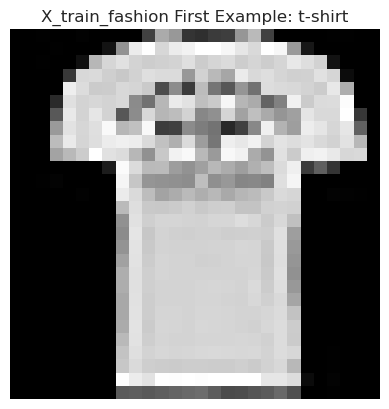

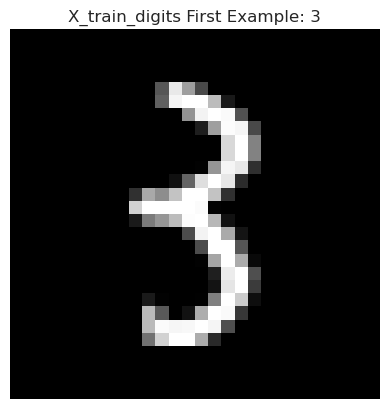

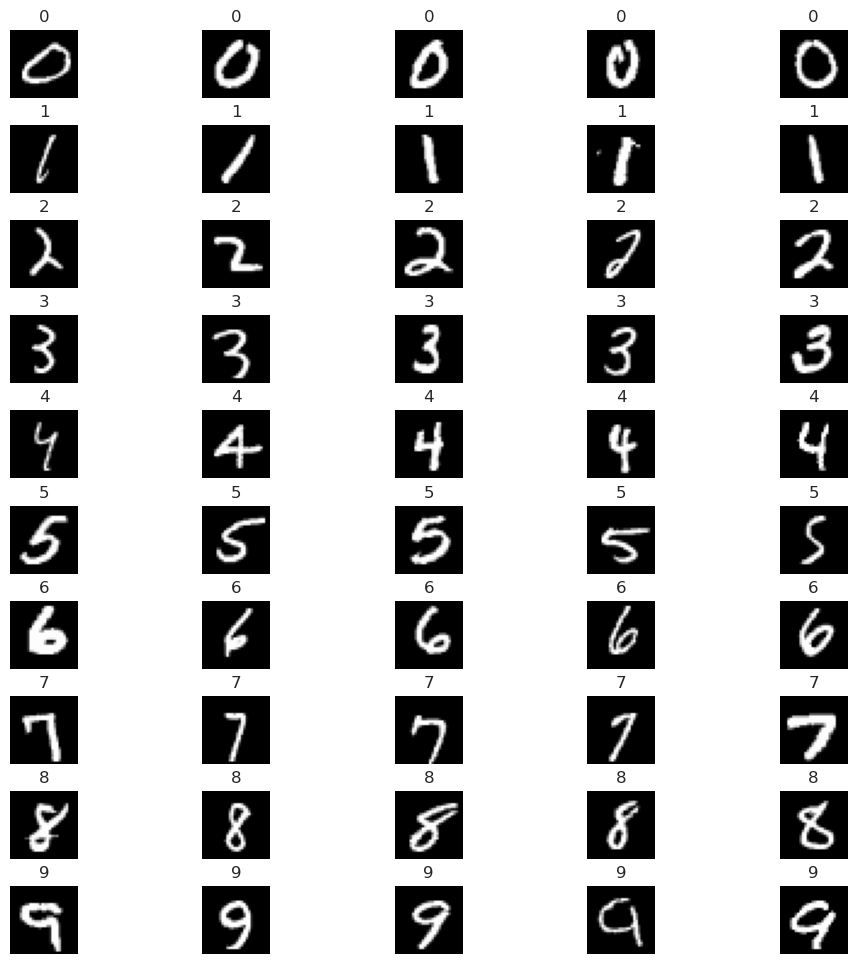

In [13]:
# 1. Show the first training example in X_train_fashion
plt.imshow(X_train_fashion[0], cmap='gray')
plt.title(f"X_train_fashion First Example: {label_names[Y_train_fashion[0]]}")
plt.axis('off')
plt.show()

# 2. Show the first training in X_train_digits
plt.imshow(X_train_digits[0], cmap='gray')
plt.title(f"X_train_digits First Example: {Y_train_digits[0]}")
plt.axis('off')
plt.show()


# 3. Display first five images in X_train for each class in y_train
# Create a figure to plot the 10x5 grid
fig, axes = plt.subplots(10, 5, figsize=(12, 12))
fig.subplots_adjust(hspace=0.4)

# Track how many images of each class we've plotted
count = {i: 0 for i in range(10)}

# Loop over X_train and Y_train to find the first 5 images per class
for i in range(len(X_train_digits)):
    label = Y_train_digits[i]
    if count[label] < 5:
        ax = axes[label, count[label]]
        ax.imshow(X_train_digits[i], cmap='gray')
        ax.axis('off')
        ax.set_title(label)
        count[label] += 1
    
    # Stop once we have 5 images for each class
    if all(count == 5 for count in count.values()):
        break

# Display the grid
plt.show()

### Step 4: Modeling

### <span style="color:chocolate">Exercise 2:</span> Define model (20 points)

1. Fill in the <span style="color:chocolate">build_model()</span> function below, including all the arguments listed in the function definition. Note: the activation function parameter is only for the the hidden layers; use the appropriate final classification function for the final layer.

In [26]:
def build_model(n_classes,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01,
                metric='metric'):
    """Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.
    metric: The desired metric.

    Returns:
    model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    # Initialize a sequential model
    model = tf.keras.Sequential()

    # Add a Flatten layer to ensure input is flattened regardless of input shape
    model.add(tf.keras.layers.Flatten())

    # Add hidden layers based on the configuration   
    for units in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(
            units,
            use_bias=True,                 # use a bias (intercept) param
            activation=activation,
            kernel_initializer=tf.ones_initializer,  # initialize params to 1
            bias_initializer=tf.ones_initializer,    # initialize bias to 1
            ))

    # Add output layer
    model.add(tf.keras.layers.Dense(
      units=n_classes,              # output classes
      # input_shape=(num_features, ),  # input dim
      use_bias=True,                 # use a bias (intercept) param
      activation='softmax',          # apply a sigmoid to the output
      kernel_initializer=tf.ones_initializer,  # initialize params to 1
      bias_initializer=tf.ones_initializer,    # initialize bias to 1
  ))

    # Configure the optimizer
    if optimizer == 'SGD':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'Adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer}")

    # Finally, compile the model. Select the accuracy metric. This finalizes the graph for training.
    model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=[metric])

    return model

---
### Step 5: Experiments

You can now run a suite of experiments to see how the hyperparameters and layer sizes effect model performance. 

The <span style="color:chocolate">train_and_evaluate()</span> function below can be used to run experiments and retrieve results.

Training the digits model...


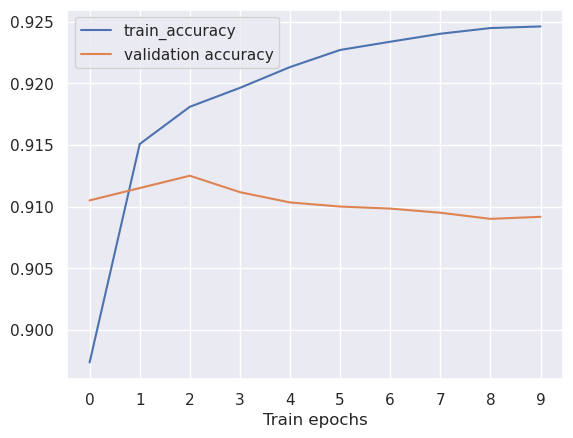

Training accuracy: 0.9246
Validation accuracy: 0.9092


In [30]:
def train_and_evaluate(data='digits',
                       hidden_layer_sizes=[],
                       activation='tanh',
                       optimizer='Adam',
                       learning_rate=0.01,
                       metric='accuracy',
                       num_epochs=10):

  # Build the model.
    model = build_model(n_classes=10,
                      hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      metric=metric,
                      learning_rate=learning_rate)

  # Select the dataset.
    if data == 'digits':
        X_train = X_train_digits
        X_test = X_test_digits
        Y_train = Y_train_digits
        Y_test = Y_test_digits
    
    elif data == 'fashion':
        X_train = X_train_fashion
        X_test = X_test_fashion
        Y_train = Y_train_fashion
        Y_test = Y_test_fashion
    else:
        raise 'Unsupported dataset: %s' %data

  # Train the model.
    print('Training the', data, 'model...')
    history = model.fit(
        x=X_train,
        y=Y_train,
        epochs=num_epochs,
        batch_size=64,
        validation_split=0.1,
        verbose=0)

    # Retrieve the training metrics (after each train epoch) and the final validation
    # accuracy.
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    plt.plot(train_accuracy, label='train_accuracy')
    plt.plot(val_accuracy, label='validation accuracy')
    plt.xticks(range(num_epochs))
    plt.xlabel('Train epochs')
    plt.legend()
    plt.show()
    
    print('Training accuracy: %1.4f' %train_accuracy[-1])
    print('Validation accuracy: %1.4f' %val_accuracy[-1])
    
    return model


# run the function
model = train_and_evaluate()

### <span style="color:chocolate">Exercise 3:</span> Ablation study (50 points)

1. Conduct experiments and record the training and validation set accuracy results in the table below. You may extend the table for additional experiments as needed.
2. Report the hyperparameter values for your preferred architecture configuration.
3. Run the model once more using your preferred hyperparameter configuration.

Data | Hidden sizes | Activation| Optimizer | Learning rate | #Parameters | Training accuracy| Validation accuracy
-|-|-|-|-|-|-|-
 digits | [] | tanh | SGD |0.01| 7850 | 0.9008|0.9033
 digits | [] | relu | SGD |0.01| 7850 |0.9008 |0.9033
 digits | [] | relu | Adam |0.01| 7850 |0.9246 |0.9092
 digits | [128] | relu | Adam |0.01| 101770 |0.6046 |0.6007
 digits | [256, 128] | relu | Adam |0.01| 235146 |0.3396 |0.3490
digits_optimal | [] | relu | Adam |0.001| 7850 |0.9292 |0.9230
fashion_optimal | [] | relu | Adam |0.0008| 7850 |0.8637 |0.8437
 fashion | [] | tanh | SGD |0.01| 7850 |0.8362 |0.8240
 fashion | [] | relu | SGD |0.01| 7850 |0.8362 |0.8240
 fashion | [] | relu | Adam |0.01| 7850 |0.8507 |0.8260
 fashion | [128] | relu | Adam |0.01| 101770 |0.6795 |0.6797
 fashion | [256, 128] | relu | Adam |0.01| 235146 |0.3175 |0.3180

Training the digits model...


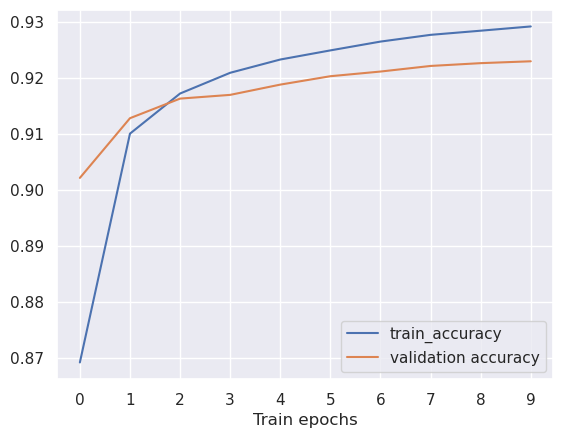

Training accuracy: 0.9292
Validation accuracy: 0.9230


In [44]:
model_digit = train_and_evaluate(data='digits', hidden_layer_sizes=[], activation='relu', optimizer='Adam',learning_rate=0.001)

Training the fashion model...


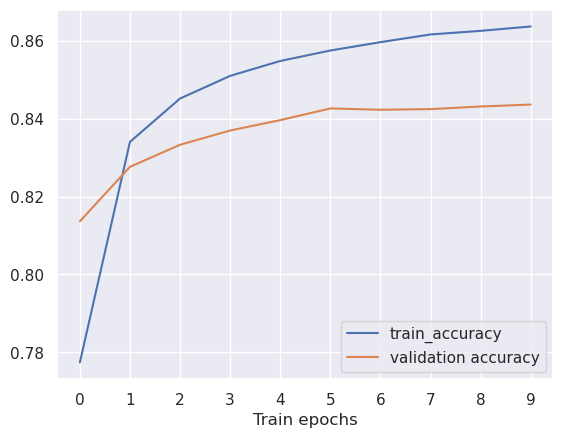

Training accuracy: 0.8637
Validation accuracy: 0.8437


In [47]:
model_fashion = train_and_evaluate(data='fashion', hidden_layer_sizes=[], activation='relu', optimizer='Adam',learning_rate=0.0008)

---
### Step 6: Evaluation and Generalization

### <span style="color:chocolate">Exercise 4:</span> Compute metrics (25 points)

Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

1. Calculate accuracy on both train and test datasets. Note: you will need to convert the vector of predicted probabilities to a class label using the argmax operation. Hint: You can utilize the <span style="color:chocolate">model.predict()</span> method provided by tf.keras and the <span style="color:chocolate">np.max()</span> method available in NumPy; or you can use the <span style="color:chocolate">model.evaluate()</span> method provided by tf.keras directly.

2. Does the model demonstrate strong generalization capabilities? Provide an explanation based on your accuracy observations.

In [50]:
# 1a. Evaluate accuracy on the training dataset for Digits
train_loss, train_accuracy = model_digit.evaluate(X_train_digits, Y_train_digits, verbose=0)
print(f"Digits Model Training Accuracy: {100*train_accuracy:.4f}%")

# 1b. Evaluate accuracy on the test dataset for Digits
test_loss, test_accuracy = model_digit.evaluate(X_test_digits, Y_test_digits, verbose=0)
print(f"Digits Model Test Accuracy: {100*test_accuracy:.4f}%")

# 1c. Evaluate accuracy on the training dataset for Fashion
train_loss, train_accuracy = model_fashion.evaluate(X_train_fashion, Y_train_fashion, verbose=0)
print(f"Fashion Model Training Accuracy: {100*train_accuracy:.4f}%")

# 1d. Evaluate accuracy on the test dataset for Fashion
test_loss, test_accuracy = model_fashion.evaluate(X_test_fashion, Y_test_fashion, verbose=0)
print(f"Fashion Model Test Accuracy: {100*test_accuracy:.4f}%")

Digits Model Training Accuracy: 93.0133%
Digits Model Test Accuracy: 92.5700%
Fashion Model Training Accuracy: 86.5300%
Fashion Model Test Accuracy: 84.5100%


2. With an accuracy difference of at most 2% between the test and train models for fashion and digits dataset, the model can be said to generalize well. Both models score above 84% in accuracy demonstrating its validity. Furthermore, the miniscule gap in accuracy between test and train shows strong generalization potential.